<a id='top'></a>

# London Crime Analysis and Prediction | Continous Assessment
#### Ayush Bhargava(19210773)     Abhishek Rathor(19210842)    MCM- CA683
<hr>


## Table of Contents
1. [Parameters tuning](#tuning)
2. [Range Prediction](#range)
    1. [Multiclassification](#multiclass) 
    2. [Multiclassification Results](#mresult)
3. [LSOA prediction](#lsoa) 
    1. [Model Selection and interpretaion](#random)
    2. [Assumption Evaluation](#eval)
4. [Conclusions](#concl)


The goal of our analytic proposal is to output a parametric model capable of predicting the number of crimes in an LSOA or borough. We choose a time-series approach and before proceeding we need some data preparation steps.

We have proposed an autoregression model (ARIMA) that predicts the number of crimes in a borough as our analytical solution and analysed its performances compared to dummy baselines. ARIMA outperformed dummy regressors but there was little space for improvements with such models beacause of the high impredictability of the crime phenomenon. 

After discussing the further directions of the projec,we decided to **change the granularity** of our analysis:

 - *prediction granularity*:  instead of predicting the number of crimes we will consider **ranges** of values at **borough** level thus transforming the regression problem into a classification one.
 
 - *learning/data granularity*: hoping that locality will increase the stability of the time series, we will predict the number of crimes at **LSOA** level.
 
In this way instead of having a single parametric model for both LSOA and borough we'll have two different tasks.
We decided to solve two separate problems at different granularities because boroughs' time series have values that vary in wider range than the LSOA's ones, resulting in more unstable series. 
 
For the proposed solution we used a dataset in which there is a record for each LSOA and couple year-month. In each record we have one numerical attribute for each major category of felony that contains the sum of the values of that kind of crime in the specific month and LSOA. 

Furthermore each model/algorithm has been evaluated with a Time-Series Cross-Validation approach in which:
 1. we split the time series in folds of equal length
 2. in the $i^{th}$ itearation the model is trained up to the $i-1^{th}$ fold and tested on the $i^{th}$. In this way we never use future observation to predict past ones. The first fold is used only for training and we start testing from the second one;
 3. the results of each iteration are aggregated and for each cross validation we collect these aggregated scoers.

In [41]:
import util as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

<a id='tuning'></a> 
## 1. Parameters Tuning [to top](#top)

Each model has been evaluated using time series cross validation on normalized data. We collect scores for each combination of algorithms and parameters. The code below shows and example of random forest parameter tuning execution.

In [ ]:
"""
Takes A LOT of time (3/4h)

%%time

#scores = []

parms = {
    'n_est':range(1, 27, 2),
    'max_depth':[None, 4, 6, 10, 20],
    'min_samples_split':[x / 100.0 for x in range(5, 45, 5)],
    'previous_obs':range(2, 13)
}

ranges = {
    "train":["2011-01-01", "2016-12-01"],
    "test": ["2017-01-01", "2017-02-02"]
}

ts = u.get_lsoa_ts(series, u.critic_lsoa[0])['value']
ts_norm, scaler = normalize_data(ts)
ts_norm = pd.Series(index=ts.index, data=ts_norm)
to_predict = 1
alg_str = 'random_forest'
folds = 6
exc = 0
for n_est in parms['n_est']:
    for depth in parms['max_depth']:
        for prev_ob in parms['previous_obs']:
            prev_obs = prev_ob
            d = u.train_test(ts_norm, ranges, prev_obs, to_predict)
            if depth == None:
                for mss in parms['min_samples_split']:
                    param = {
                        'bootstrap':True, 'n_jobs':-1, 
                        'n_estimators': n_est, 'max_depth': depth, 'min_samples_split':mss
                    }
                    try:
                        ev_mean, ev_std, mae_mean, mae_std, r2_mean, r2_std ,corr_mean, corr_std, param = 
                        u.performTimeSeriesCV(np.array(d['train']['x']), np.array(d['train']['y']), folds, alg_str, param, print_all = False)

                        scores.append([alg_str, prev_obs, ev_mean, ev_std, mae_mean, mae_std, r2_mean, r2_std ,corr_mean, corr_std, param])
                    except:
                        exc += 1
                        continue;  
            else:
                param = {
                    'bootstrap':True, 'n_jobs':-1, 
                    'n_estimators': n_est, 'max_depth': depth
                }
                try:
                    ev_mean, ev_std, mae_mean, mae_std, r2_mean, r2_std ,corr_mean, corr_std, param = u.performTimeSeriesCV(np.array(d['train']['x']), np.array(d['train']['y']), folds, alg_str, param, print_all = False)
                    u.scores.append([alg_str, prev_obs, ev_mean, ev_std, mae_mean, mae_std, r2_mean, r2_std ,corr_mean, corr_std, param])
                except:
                    exc += 1
                    continue;

print 'Final corr Scores'
u.print_sorted_scores(scores, 'corr', topk=3);

"""

Among the different parameters to tune there is the one that controls the learning granularity: ``prev_obs``. Regressors and classifiers need data split into sample and targets. Each sample can have a set of attributes. In our case we have a variable number of attributes, namely the number of crimes in the previous months, and just one output variable, the next month's value. The table below shows samples and targets for a toy-time-series $[1, 2, 3, 4, 5, 6]$ with ``prev_obs`` = 3: 

Sample (1x``prev_obs``) | Target (1x1)
------------ | -------------
1, 2, 3  |  4 
2, 3, 4  |  5                          
3, 4, 5  |  6                

<a id='range'></a>
## 2. Range Prediction [to top](#top) 
We decide to change approach switching from a value prediction to a range prediction, basically from regression to a multi-classification problem. 

First of all we had to transform the values in ranges/classes through a discretization.
We decided to have five classes of risk, from Class 1 (safe) to Class 5 (dangerous) so we performed two techniques of binning: natural and equal frequency binning.

In this section we will show the results of range prediction on **Westminster**, that is the most dangerous and unpredictable borough we've seen so far.

In [2]:
series = pd.read_csv('data/lc_time_series.csv')
s = series.drop(columns=["lsoa_code","Borough"], axis=0)
s.month = pd.to_datetime(s.month)
s = s.groupby("month", as_index=True).sum()

C:\Users\madda\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


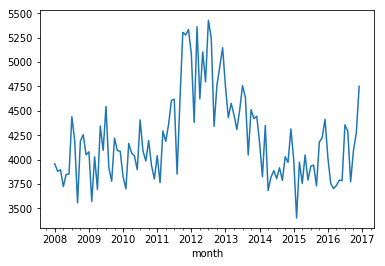

In [3]:
s_bor = u.get_bor_ts2(series, 'Westminster')['value']
s_bor.plot()

In [5]:
s_bor = u.get_bor_ts2(series, 'Westminster')
df=s_bor

C:\Users\madda\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### Natural binning (intervals with the same size)

Natural binning
1 --> 21  (3400.975, 3808.0]
2 --> 42  (3808.0, 4213.0]
3 --> 27  (4213.0, 4618.0]
4 --> 9  (4618.0, 5023.0]
5 --> 9  (5023.0, 5428.0]
----------------------------------------


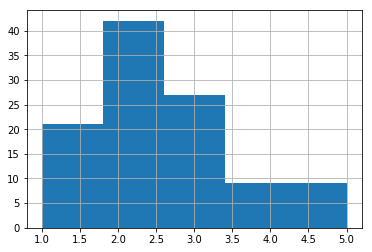

In [8]:
k=5
df['nat_bins'] = pd.cut(df['value'], bins=k, labels=np.arange(1,k+1,1))

#Showing the frequency of each bin
s_bor["nat_bins"].hist(bins=k)
ints = pd.cut(df['value'], bins=k, retbins=True)[1]

print ("Natural binning")
for i in range(1,k+1):
    print (str(i) +" --> "+ str(len(df[df["nat_bins"]==i])) + "  ("+str(ints[i-1])+", "+str(ints[i])+"]")
print ("----------------------------------------")

#### Equal frequency binning (Intervals with the same frequency)

Equal freq. binning
1 --> 22  (3403.0, 3822.6]
2 --> 22  (3822.6, 4029.0]
3 --> 21  (4029.0, 4231.2]
4 --> 21  (4231.2, 4531.8]
5 --> 22  (4531.8, 5428.0]
----------------------------------------


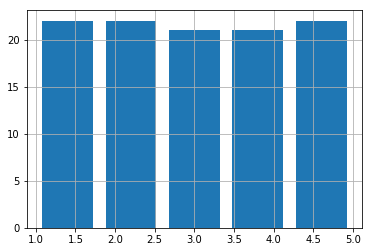

In [9]:
k=5
df['eq_bins'] = pd.qcut(df['value'], q=k, labels=np.arange(1,k+1,1))

#Showing the frequency of each bin

s_bor["eq_bins"].hist(bins=k, rwidth=0.8)
ints2 = pd.qcut(df['value'], q=k, retbins=True)[1]

print ("Equal freq. binning")
for i in range(1,k+1):
    print (str(i) +" --> "+ str(len(df[df["eq_bins"]==i])) + "  ("+str(ints2[i-1])+", "+str(ints2[i])+"]")
print ("----------------------------------------")

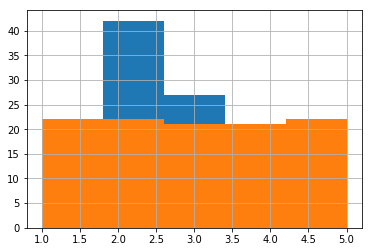

In [10]:
s_bor["nat_bins"].hist(bins=k)
s_bor["eq_bins"].hist(bins=k)

We preferred to use a balanced solutions, so, for Westminster we obtain five classes of risk as follows:
- **CLASS 1**: $\approx 120.42\space crimes/day$
- **CLASS 2**: $\approx 130.86\space crimes/day$
- **CLASS 3**: $\approx 137.67\space crimes/day$
- **CLASS 4**: $\approx 146.05\space crimes/day$
- **CLASS 5**: $\approx 166.00\space crimes/day$

In [11]:
#Converting the eq_bins attribute to an integer value
bin_name="eq_bins"
s_bor[bin_name]=pd.to_numeric(s_bor[bin_name])

we show now the transformed time series of Westminster

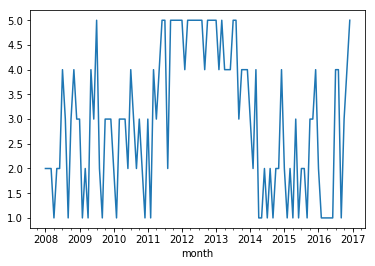

In [12]:
d = s_bor["eq_bins"]
d.plot()

We also comupute two dummy baselines to compare the results. The first dummy classifier outputs the average class, rounded to the closest integer, the second one is a random dummy classifier.

The error is given by the MAE that is simply the difference between the predicted and the true class.

In [114]:
ranges = {
    "train":["2009-01-01", "2016-12-01"],
    "test": ["2017-12-01", "2018-12-01"]
}

ts=d
prev_obs = 4
to_predict = 1
n_folds=5

data = u.train_test(ts, ranges, prev_obs, to_predict)

In [61]:
u.performTimeSeriesCV2(np.array(data['train']['x']), np.array(data['train']['y']), n_folds, 'dummy_avg', [], print_all = False);

---------------------------------
avg(mae) =  1.551062091503268  std dev =  0.19085979791726504


C:\Users\madda\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\madda\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [120]:
u.performTimeSeriesCV2(np.array(data['train']['x']), np.array(data['train']['y']), n_folds, 'dummy_rand', [], print_all = False);

---------------------------------
avg(mae) =  1.8088235294117647  std dev =  0.42899859252396527


<a id='multiclass'></a>
### 2.A Multi-classification [to top](#top) 
We used both Random Forest and Gradient Boost for our multiclassification task. We used cross-validation both to fix good parameters for both algorithms and to choose the best model between them. 

#### Random Forest
We tried different parameters configuration and the most accurate one for *random forest classifier* is:
- **n_estimators**= 16
- **bootstrap** = True
- **max_depth** = None
- **min_samples_leaf** = 5

In [101]:
parameters = {'n_estimators': 16, 'bootstrap': False, 'n_jobs': -1, 'max_depth': None, 'min_samples_leaf': 5}

#### Cross Validation
We can now compared  the  results  of  the  random  forest  model  with  the  dummy  regressors  cross-validated
over the data of the borough of Westminster. The comparison metric is metrics the **MAE** (Mean Absolute Error).

In [112]:
ranges = {
    "train":["2009-01-01", "2016-12-01"],
    "test": ["2017-12-01", "2018-12-01"]
}

ts=d
prev_obs = 2
to_predict = 1


data = u.train_test(ts, ranges, prev_obs, to_predict)

In [113]:
#The results can vary at each execution, beacause in the random forest model there is a randomic component.

u.performTimeSeriesCV2(np.array(data['train']['x']), np.array(data['train']['y']), 5, 'random_forest', parameters, print_all = True);


Splitting the first 2 chunks at 1/2
Size of train + test:  (36, 2)


C:\Users\madda\Desktop\Magistrale\Secondo Anno\BigData Analitycs\Work\Regression\util.py:296: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_rf.fit(x_trainFolds, y_trainFolds)


MAE on fold 2:  1.588235294117647

Splitting the first 3 chunks at 2/3
Size of train + test:  (54, 2)


C:\Users\madda\Desktop\Magistrale\Secondo Anno\BigData Analitycs\Work\Regression\util.py:296: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_rf.fit(x_trainFolds, y_trainFolds)
C:\Users\madda\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\madda\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\Users\madda\Desktop\Magistrale\Secondo Anno\BigData Analitycs\Work\Regression\util.py:296: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_rf.fit(x_trainFolds, y_trainFolds)


MAE on fold 3:  0.29411764705882354

Splitting the first 4 chunks at 3/4
Size of train + test:  (72, 2)
MAE on fold 4:  1.3529411764705883

Splitting the first 5 chunks at 4/5
Size of train + test:  (90, 2)


C:\Users\madda\Desktop\Magistrale\Secondo Anno\BigData Analitycs\Work\Regression\util.py:296: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_rf.fit(x_trainFolds, y_trainFolds)


MAE on fold 5:  1.1176470588235294
---------------------------------
avg(mae) =  1.0882352941176472  std dev =  0.48773893975814697


The following table shows the results of the cross-validation:

Model | avg(MAE) | dev_std 
------------ | ------------- | ------------ 
Dummy AVG  |  1.373 | 0.416 
Dummy RAND | 1.750 | 0.251                        
Random Forest  |  **1.132** | 0.564 

Let's now plot a prediction example of the best random forest: we train the model from 2008 to 2014 and try to predict the first 8 months of 2015, one month at time.

C:\Users\madda\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MAE:  0.3333333333333333
Pred [2 1 2 1 2 1]
True [2 1 3 1 2 2]


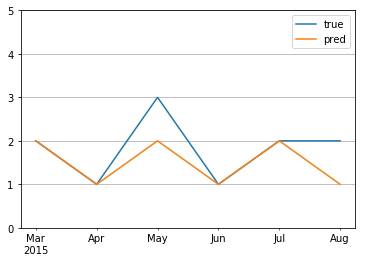

In [93]:
ranges = {
    "train":["2008-01-01", "2014-12-01"],
    "test": ["2015-01-01", "2015-08-01"]
}

ts = d
prev_obs = 2
to_predict = 1

data = u.train_test(ts, ranges, prev_obs, to_predict)

clf = u.RandomForestClassifier(**parameters)

clf.fit(data['train']['x'], data['train']['y'])

# Predict on new data
y_rf = clf.predict(data['test']['x'])
print ("MAE: ",u.print_scores(np.array(data['test']['y']).reshape(-1), y_rf, ret_scores = True)[1])

print ("Pred", y_rf)

print ("True", np.array(data['test']['y']).reshape(1,-1)[0])

#Plotting
idx = pd.date_range(start=ranges['test'][0], end=ranges['test'][1], freq="MS")[prev_obs:]
true = pd.Series(index = idx, data= np.array(data['test']['y']).reshape(-1))
pred = pd.Series(index = idx, data= y_rf)
true.plot(label = "true")
pred.plot(label = "pred")
axes = plt.gca()
axes.set_ylim([0,5])
plt.legend()
plt.grid()

#### Feature importance

Since $prev\_obs = 2$ we have a couple of features: $(Class(M_2), Class(M_1))$, where $M_1$ is the month at distance 1 from the month to predict (the previous month), similarly $M_2$ is the month at distance 2 and $Class(M_x)$ returns the Class for the month $x$.

We analyzed the feature importance for the random forest model: $Class(M_1)$ and $Class(M_2)$ have an importance of, respectively, $0.604$ and $0.395$; this means that the class of the previous month ($M_1$) is $\approx 1.5$ times more important than the class of $M_2$.

In [ ]:
clf.feature_importances_

Now we'll analyze one of the 16 trees in the model

In [83]:
"""

from sklearn.tree import export_graphviz
import graphviz
import os

tree_in_forest = clf.estimators_


class_names=[]

for i in range (1,6):
    class_names.append("Class "+str(i))


i = 0
for i in range(len(tree_in_forest)):
    dot_data = export_graphviz(tree_in_forest[i],
                    feature_names=["M_2","M_1"],
                    filled=True, class_names=class_names,
                    rounded=True, out_file = 'tree'+str(i)+'.dot')

    os.system('dot -Tpng tree'+str(i)+'.dot -o tree'+str(i)+'.png')

"""

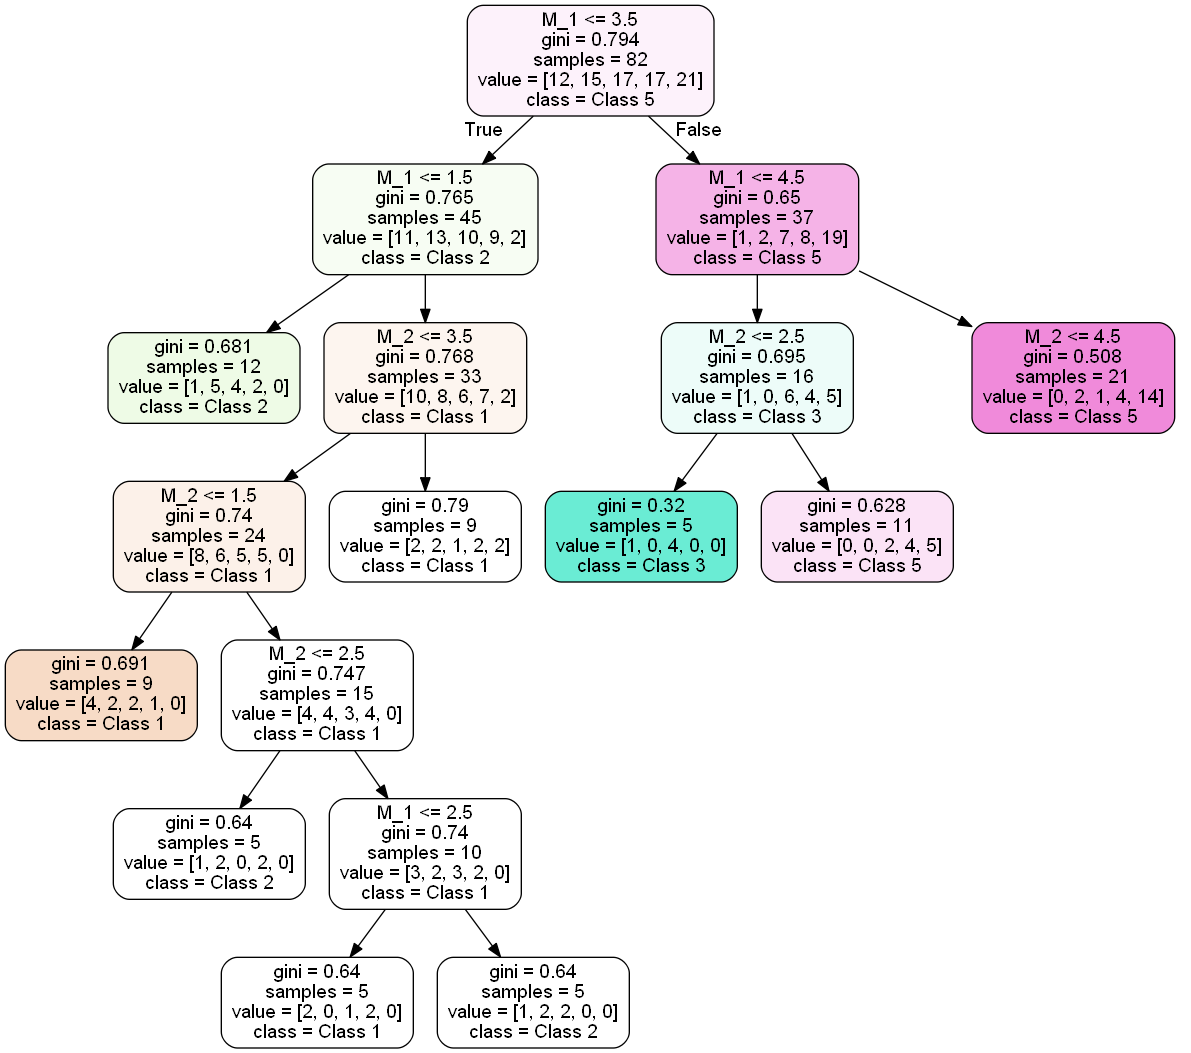imgs/decision_tree.png)

The root node splits on $Class(M_1)\leq 3.5$, if *true*, assuming we want to classify $M_{pred}$, then $Class(M_{pred}) \in \{1,2\}$ that are the "safe" classes.

The difference from a Class 1 and a Class 2 is made by $Class(M_2)$:
 - $Class(M_2) \leq 1.5$ then Class 1
 - $Class(M_2) = 2$ then Class 2
 - $Class(M_2) > 2.5 \; \wedge Class(M_1) \leq 2.5 $ then Class 1
 - $Class(M_2) > 2.5 \; \wedge Class(M_1) < 2.5 $ then Class 2

Else, if $Class(M_1)\leq 3.5$ is *false*, $Class(M_{pred}) \in \{3,5\}$ that are the "dangerous" classes.

The difference from a Class 3 and a Class 5 is made by
 - $Class(M_1) = 5$ then Class 5
 - $Class(M_1) \leq 4.5 \; \wedge Class(M_2) \leq 2.5$ then Class 3
 - $Class(M_1) \leq 4.5 \; \wedge Class(M_2) > 2.5$ then Class 5

#### Gradient Boosting
We used the *gradient boosting classifier*, also  this  time  several  configurations  were  evaluated;  the
best-one with respect to the MAE has this parameters:

- **n_estimators**= 10
- **learning_rate** = 0.17
- **max_depth** = 4
- **min_samples_leaf** = 2
- **min_samples_split** = 2
- **subsample** = 0.8
- **random_state** = 10

In [47]:
parameters={'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 
            'learning_rate': 0.17, 'subsample': 0.8, 'random_state': 10}

In [49]:
ranges = {
    "train":["2009-01-01", "2016-12-01"],
    "test": ["2017-12-01", "2018-12-01"]
}

ts=d
prev_obs = 2
to_predict = 1


data = u.train_test(ts, ranges, prev_obs, to_predict)

In [51]:
u.performTimeSeriesCV2(np.array(data['train']['x']), np.array(data['train']['y']), 5, 'gradient_boost', parameters, print_all = True);


Splitting the first 2 chunks at 1/2
Size of train + test:  (36, 2)
MAE on fold 2:  1.2352941176470589

Splitting the first 3 chunks at 2/3
Size of train + test:  (54, 2)
MAE on fold 3:  0.29411764705882354

Splitting the first 4 chunks at 3/4
Size of train + test:  (72, 2)
MAE on fold 4:  1.2352941176470589

Splitting the first 5 chunks at 4/5
Size of train + test:  (90, 2)
MAE on fold 5:  0.9411764705882353
---------------------------------
avg(mae) =  0.9264705882352942  std dev =  0.3843274807462347


C:\Users\madda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\madda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\madda\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\madda\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\Users\madda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d ar

The cross-validation resulted in these scores:

Model | avg(MAE) | dev_std 
------------ | ------------- | ------------ 
Dummy AVG  |  1.373 | 0.416 
Dummy RAND | 1.750 | 0.251                        
Gradient Boosting  |  **0.926** | 0.384 

Again we plot a prediction example of the best execution.

MAE:  0.6666666666666666
Pred [2 1 2 3 2 1]
True [2 1 3 1 2 2]


C:\Users\madda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


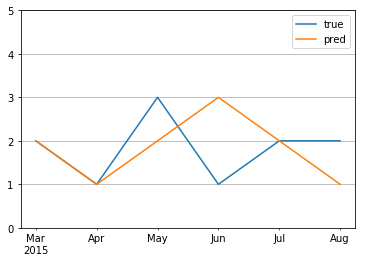

In [53]:
ranges = {
    "train":["2008-01-01", "2014-12-01"],
    "test": ["2015-01-01", "2015-08-01"]
}

ts = d
prev_obs = 2
to_predict = 1

data = u.train_test(ts, ranges, prev_obs, to_predict)

clf = u.GradientBoostingClassifier(**parameters)

clf.fit(data['train']['x'], data['train']['y'])

# Predict on new data
y_rf = clf.predict(data['test']['x'])
print ("MAE: ",u.print_scores(np.array(data['test']['y']).reshape(-1), y_rf, ret_scores = True)[1])

print ("Pred", y_rf)

print ("True", np.array(data['test']['y']).reshape(1,-1)[0])


#Plotting
idx = pd.date_range(start=ranges['test'][0], end=ranges['test'][1], freq="MS")[prev_obs:]
true = pd.Series(index = idx, data= np.array(data['test']['y']).reshape(-1))
pred = pd.Series(index = idx, data= y_rf)
true.plot(label = "true")
pred.plot(label = "pred")
axes = plt.gca()
axes.set_ylim([0,5])
plt.legend()
plt.grid()

The optimal $prev\_obs$ is again $2$, so we analyze the importance feature of $(Class(M_2), Class(M_1))$; this time the importance is more balanced, in fact is, respectively of $0.466$ and $0.533$.

In [54]:
clf.feature_importances_

array([0.46675941, 0.53324059])

<a id="mresult"></a>
### 2.B Multiclassification Results [to top](#top)

We now compare random forest and gradient boosting with the dummy regressos both in statistical and visual terms.
We first plot the execution of models trained from 2008 to late 2014 and tested on February, March, April and May of 2015.

C:\Users\madda\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\madda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\madda\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\madda\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


MAE [RF]:  0.25
MAE [GB]:  0.25
MAE [AV]:  1.25
MAE [RD]:  1.25
Pred [RF]:  [1 2 1 2]
Pred [GB]:  [1 2 1 2]
Pred [AV]:  [3 3 3 3]
Pred [RD]:  [2, 1, 3, 2]
True [1 2 1 3]


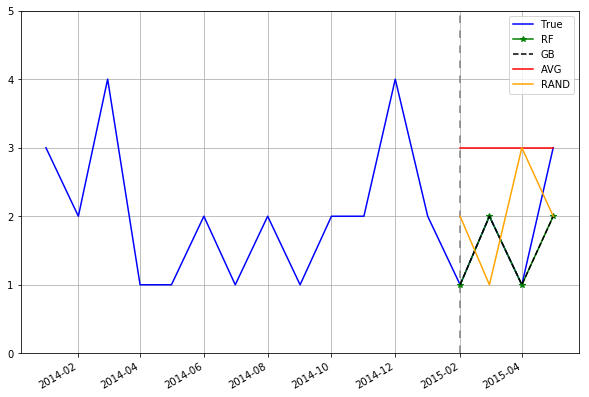

In [121]:
ranges = {
    "train":["2008-01-01", "2014-11-01"],
    "test": ["2014-12-01", "2015-05-01"]
}

ranges2 = {
    "train":["2014-01-01", "2014-11-01"],
    "test": ["2014-12-01", "2015-05-01"]
}

ts = d
prev_obs = 2
to_predict = 1

data = u.train_test(ts, ranges, prev_obs, to_predict)

#GRAPH SETTINGs

plt.figure(figsize=(10,7))
axes = plt.gca()
axes.set_ylim([0,5])



#TRUE line
train = d.loc[ranges2['train'][0]:ranges2['train'][1]]
test = d.loc[ranges2['test'][0]:ranges2['test'][1]]

tot = train.append(test)

#VERTICAL LINE
plt.plot((pd.to_datetime("2015/02/01"), pd.to_datetime("2015/02/01")), (0, 5), 'grey', dashes=[5,5])


#RANDOM_FOREST ***********************************************************

parameters = {'n_estimators': 16, 'bootstrap': False, 'n_jobs': -1, 'max_depth': None, 'min_samples_leaf': 5}

random_forest = u.RandomForestClassifier(**parameters)

random_forest.fit(data['train']['x'], data['train']['y'])

# Predict on new data
y_rf = random_forest.predict(data['test']['x'])



#GRADIENT_BOOSTING ***********************************************************

parameters={'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 
            'learning_rate': 0.17, 'subsample': 0.8, 'random_state': 10}

gradient_boosting = u.GradientBoostingClassifier(**parameters)

gradient_boosting.fit(data['train']['x'], data['train']['y'])

# Predict on new data
y_gb = clf.predict(data['test']['x'])


#DUMMYS CLASSIFIERS

y_avg = u.dummy_avg(data['train']['y'], data['test']['y'])

y_rnd = u.dummy_range(1,5, data['test']['y'])
#for obtain the same result
y_rnd = [2,1,3,2]


#PRINT SCORES

print ("MAE [RF]: ",u.print_scores(np.array(data['test']['y']).reshape(-1), y_rf, ret_scores = True)[1])
print ("MAE [GB]: ",u.print_scores(np.array(data['test']['y']).reshape(-1), y_gb, ret_scores = True)[1])
print ("MAE [AV]: ",u.print_scores(np.array(data['test']['y']).reshape(-1), y_avg, ret_scores = True)[1])
print ("MAE [RD]: ",u.print_scores(np.array(data['test']['y']).reshape(-1), y_rnd, ret_scores = True)[1])

print ("Pred [RF]: ",y_rf)
print ("Pred [GB]: ",y_gb)
print ("Pred [AV]: ",y_avg)
print ("Pred [RD]: ",y_rnd)
print ("True", np.array(data['test']['y']).reshape(1,-1)[0])


#Plotting
idx = pd.date_range(start=ranges2['test'][0], end=ranges2['test'][1], freq="MS")[prev_obs:]
true = pd.Series(index = idx, data= np.array(data['test']['y']).reshape(-1))

predRF = pd.Series(index = idx, data= y_rf)
predGB = pd.Series(index = idx, data= y_gb)
predDAvg = pd.Series(index = idx, data= y_avg)
predDRand = pd.Series(index = idx, data= y_rnd)

plt.plot(tot, label = "True", color="blue")
predRF.plot(label = "RF", color="green", marker="*")
predGB.plot(label = "GB", color="black",linestyle="--")
predDAvg.plot(label = "AVG", color="red")
predDRand.plot(label = "RAND", color="orange")


plt.grid()
plt.legend()
plt.savefig("finale.png")

then we show a table that compares the scores collected with the cross-validation.

Model | avg(MAE) | dev_std | predicted(1,2,1,3) | MAE(test)
------------ | ------------- | ------------ | ------------- | ------------- 
Dummy AVG  |  1.373 | 0.416 | (3, 3, 3, 3)| 1.25
Dummy RAND | 1.808 | 0.428 | (2, 1, 3, 2) | 1.25                        
Random Forest  |  1.088 |0.487 | (1,2,1,2) | 0.25
Gradient Boosting | **0.926** | 0.384 | (1,2,1,2) | 0.25

The best model in this case is the Gradient Boosting since it has a greater accuracy (lowest value of MAE) and is more stable (lower standard deviation than Random Forest).



<a id='lsoa'></a>
## 3. LSOA Prediction [to top](#top) 

In the data understanding phase we spotted LSOA in London where the crime value is always high all over the years. The gif below shows our previous results.
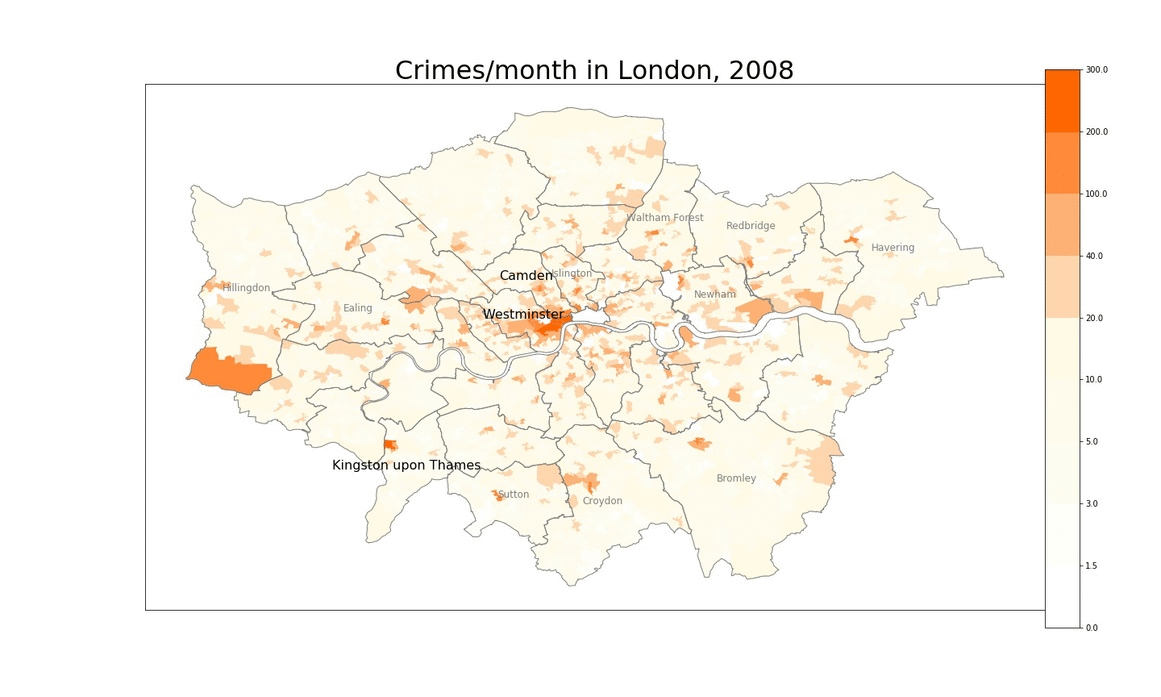

We then performed clustering to understand if and how LSOA can be grouped and characterized in some meaningfull way. We used as clustering attributes the number of crimes within a specific category.

Among all major crime categories used, three of them separate LSOA in dangerousness classes. 

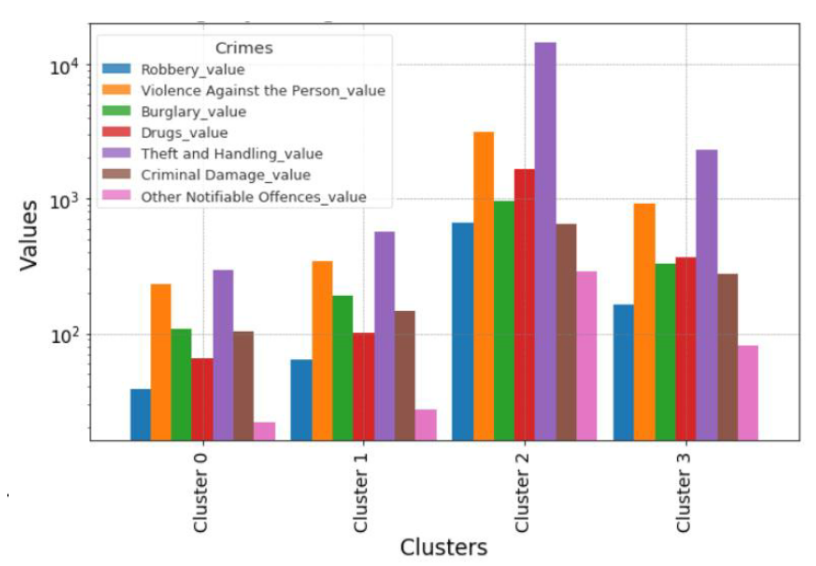

As this bar plot shows cluster 2 contains (very few) LSOA with very high crime values. We decided to focus our analysis on this cluster of dangerous LSOA. We will propose a model for a generic LSOA in cluster 2 and assume that this model approximate *well* also the behavoir of LSOA in the same cluster. Then we will validate our assumption looking at how the selected model works and performs.

LSOA in cluster 2 belong to the previously discovered dangerous boroughs, namely the ones in black in the map: Camden, Croydon, Hillingdon, Islington, Westminister and Hackney. We search for the model that best fits the first LSOA in the list, that belongs to Camden. 

Following a [crime prediction work](https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-018-0150-z), we choose to try three regressors: RandomForest, ExtraTrees and GradientBoost.

In [122]:
series = pd.read_csv('data\LC_ts.csv')
series.rename(columns={'period':'month'}, inplace=True)
series.head(2)

,lsoa_code,borough,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person,value,month
0,E01000006,Barking and Dagenham,1.0,1.0,0.0,0.0,0.0,2.0,0.0,7.0,5.0,16.0,2008-1
1,E01000007,Barking and Dagenham,0.0,1.0,6.0,1.0,0.0,0.0,1.0,10.0,10.0,29.0,2008-1


<a id='random'></a> 
### 3.A Model Selection and interpretaion [to top](#top)

For each best configuration and cross validation we collected four scores:
 - *Explained Variance EV*: is a measure for the prediction accuracy. The best possible score is 1.0, lower values are worse.
 - *Mean Absolute Error MAE* 
 - *R2*
 - *Pearson Correlation*

We search for the best configuration for each regressor and compared the results also with a dummy baseline. The performances are summarized in the table below.

 
Model | EV | MAE | R2 | Corr
------------ | ------------- | ------------ | ------------- | -------------
Random Forest  |  0.13 | **0.113** | **-0.255** | **0.47** 
Extra Trees  | 0.16 | 0.119 | -0.338 | 0.4                          
Gradient Boost  |  **0.17** | 0.134 | -0.47 | 0.46
Dummy_avg | 0 | 0.14 | -0.87 | 

All best configurations outperformed the baseline, and among them, the random forest reaches the best performaces in terms of all scores but one, so we choose to analyse it.

The optimal parameter configuration is:
 
Parameter | value 
------------ | -------------
prev_obs  |  9 
max_depth  | None                          
n_estimators  | 5

where max_depth is the maximum depth of the generic tree in the forest and n_estimators is the number of three composing the forest. As first step we plot the feature importance. In this execution we'll have 9 features, one for each prev_obs.

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


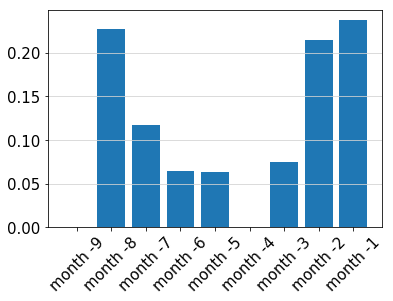

In [19]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

ranges = {
    "train":["2011-01-01", "2016-12-01"],
    "test": ["2017-01-01", "2017-02-02"]
}

#Get the LSOA time series and normalize
ts = u.get_lsoa_ts(series, u.critic_lsoa[0])['value']
ts_norm, scaler = u.normalize_data(ts)
ts_norm = pd.Series(index=ts.index, data=ts_norm);

#Set random forest best parameters and prepare the data for regression
param = {'n_jobs': -1, 'bootstrap': True, 'n_estimators': 5, 'criterion': 'mse', 'min_samples_split': 0.25, 'max_depth': None}
prev_obs = 9
to_predict = 1
d = u.train_test(ts_norm, ranges, prev_obs, to_predict)

x_trainFolds = d['train']['x'][:40]
y_trainFolds = d['train']['y'][:40]
x_testFold = d['train']['x'][40:50]
y_testFold = d['train']['y'][40:50]

#Train
model = RandomForestRegressor(**param)
model.fit(x_trainFolds, y_trainFolds)

#Test
y_pred = model.predict(x_testFold)

#Plot Feature Importance
xt = [ ("month -" + str(i+1)) for i in range(prev_obs-1, -1, -1)]
plt.bar(xt, model.feature_importances_)
plt.xticks(rotation = 45, fontsize=15)
plt.yticks(fontsize = 15)
#plt.title("Feature importance in the best RandomForestRegressor", fontsize=20)
plt.grid(axis='y', c='lightgrey')
plt.show()

The bar plot shows that the most important measurements for predicting of the total number of crimes that will occurr in the next month are **again** the one collected in the previous two months and the one collected 8 months before. 
As we can see also from the autocorrealtion plot, this time series has positive and significant autocorrelation at lags 1 and 2, so we can expect some recurring behaviour in small temporal ranges.

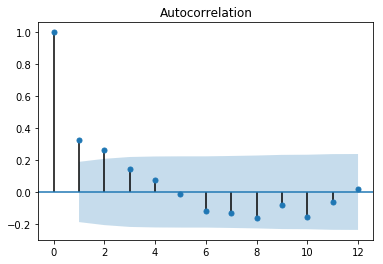

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_norm, lags=12);

<a id='eval'></a> 
### 3.B Assumption Evaluation [to top](#top)
Now we will evaluate our assumption that was that a model trained on a *critic* LSOA approximates well also the behavoir of LSOAs in the same cluster.

We use the random forest model with the parameter estimated in the previous step and we perform a Cross Validation where:
For each step $i$ of the Cross validation we build a Random Forest regressor $RF_i$ that is trained in the current fold of the LSOA of reference, than we test $RF_i$ on the others LSOAs and we collect the results in terms of *EV*, *MAE*, *R2* and *Correlation*.

In [41]:
n_n=["ev","mae","r2","corr"]

n_v=[0.13, 0.113, -0.255, 0.47]

score_dummy = [-1.036208156316813e-17, 0.1559898529932095, -2.64674745989479]


def plot_score_lsoa(dic, dic2, metric, label, title):
    y=[]
    
    x=dic.keys()
    
    for k in x:
         y.append(dic[k][metric].mean())
        
    #Plotting
    fig = u.plt.figure(figsize=(10,6))
    avg=np.array(y).mean()
    u.plt.xticks(rotation=45)
    u.plt.grid(color='grey', linestyle='--', linewidth=0.5)
    u.plt.title(title)
    
    
    #avg line
    avg1= u.plt.plot((0, 14), (avg, avg), 'grey', label = "AVG")
    
    #LSOA critic 0 line
    ind2 = n_n.index(metric)
    s = n_v[ind2]
    u.plt.plot((0, 14), (s, s), 'red', dashes=[5,5], label = "Ref")
    
    if metric != "corr":
        ind = n_n.index(metric)  
        avg2=u.plt.plot((0, 14), (score_dummy[ind], score_dummy[ind]), 'orange', label = "AVG_dummy", linestyle=":", marker="*", linewidth=3)
        
        u.plt.fill_between(np.arange(0,15,1),s,score_dummy[ind], color="lightgreen", alpha=0.5)
    else:
        u.plt.fill_between(np.arange(0,15,1),s,avg, color="lightgreen", alpha=0.5)
        
    
    u.plt.plot(x,y, label = label, color="blue", marker=".", markersize=7)
    
    

    u.plt.legend()

In [21]:
from sklearn.dummy import *

warnings.filterwarnings('ignore')

ranges = {
    "train":["2011-01-01", "2016-12-01"],
    "test": ["2017-01-01", "2017-02-02"]
    }

#Parameters
alg_str = 'random_forest'
number_folds = 6
prev_obs = 9
to_predict = 1
param = {'n_jobs': -1, 'bootstrap': True, 'n_estimators': 5, 'criterion': 'mse', 'min_samples_split': 0.25, 'max_depth': None}

regr_rf = u.RandomForestRegressor(**param)

ls_model=u.get_lsoa_ts(series, u.critic_lsoa[0])['value']
ls_model_norm, scaler_model = u.normalize_data(ls_model)
ls_model_norm=pd.Series(index=ls_model.index, data=ls_model_norm)

dic={}
for i in range(1,len(u.critic_lsoa)):
    dic[u.critic_lsoa[i]]=({'ev':np.zeros(number_folds-1),
                         'mae':np.zeros(number_folds-1),
                         'r2':np.zeros(number_folds-1),
                          'corr':np.zeros(number_folds-1)})
    
dic2={}
for i in range(1,len(u.critic_lsoa)):
    dic2[u.critic_lsoa[i]]=({'ev':np.zeros(number_folds-1),
                         'mae':np.zeros(number_folds-1),
                         'r2':np.zeros(number_folds-1)})    
    
    
for i in range(2, number_folds + 1):
    
    d = u.train_test(ls_model_norm, ranges, prev_obs, to_predict)
    X_train=np.array(d['train']['x'])
    y_train=np.array(d['train']['y'])
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    
    split = float(i-1)/i
    X = X_train[:(k*i)]
    y = y_train[:(k*i)]
    
    index = int(np.floor(X.shape[0] * split))
        
    x_trainFolds = X[:index]        
    y_trainFolds = y[:index]
    
    for l in range(1,len(u.critic_lsoa)):
    
        #Get the LSOA time series and normalize
        ts = u.get_lsoa_ts(series, u.critic_lsoa[l])['value']
        ts_norm, scaler_ = u.normalize_data(ts)
        ts_norm =pd.Series(index=ts.index, data=ts_norm)
    
        lsoa_ = u.train_test(ts_norm, ranges, prev_obs, to_predict)
        X_train_l=np.array(lsoa_['train']['x'])
        y_train_l= np.array(lsoa_['train']['y'])
    
        X_l = X_train_l[:(k*i)]
        y_l = y_train_l[:(k*i)]
        
        x_testFold = X_l[(index + 1):]
        y_testFold = y_l[(index + 1):]
        
        regr_rf.fit(x_trainFolds, y_trainFolds)      
        y_pred = regr_rf.predict(x_testFold)
        
        dummy  = DummyRegressor(strategy='mean')
        dummy.fit(x_trainFolds, y_trainFolds)
        y_avg = dummy.predict(x_testFold)
        
        
        
        ss = u.print_scores(np.array(y_testFold).reshape(-1), np.array(y_pred).reshape(-1), ret_scores=True)
                          
        dic[u.critic_lsoa[l]]['ev'][i-2]=ss[0]
        dic[u.critic_lsoa[l]]['mae'][i-2]=ss[1]
        dic[u.critic_lsoa[l]]['r2'][i-2]=ss[2]
        dic[u.critic_lsoa[l]]['corr'][i-2]=ss[3]
        
        ss2 = u.print_scores(np.array(y_testFold).reshape(-1), np.array(y_avg).reshape(-1), ret_scores=True)
                          
        dic2[u.critic_lsoa[l]]['ev'][i-2]=ss2[0]
        dic2[u.critic_lsoa[l]]['mae'][i-2]=ss2[1]
        dic2[u.critic_lsoa[l]]['r2'][i-2]=ss2[2]
        


for name in dic.keys():
    print('LSOA: ',name)
    for measure in dic[name].keys():
        print('avg(', measure,') = ', dic[name][measure].mean(), 'std dev = ',   dic[name][measure].std())
    print('-------------------------------')
    print()

('LSOA: ', 'E01033595')
('avg(', 'ev', ') = ', 0.2679869902675381, 'std dev = ', 0.20501424184106232)
('avg(', 'mae', ') = ', 0.14760534510622195, 'std dev = ', 0.05953948326237563)
('avg(', 'corr', ') = ', 0.5579163573075288, 'std dev = ', 0.2936902536659386)
('avg(', 'r2', ') = ', -0.4562233881433251, 'std dev = ', 0.6287811940224766)
-------------------------------
()
('LSOA: ', 'E01000914')
('avg(', 'ev', ') = ', -0.06323369979255375, 'std dev = ', 0.17422088249877887)
('avg(', 'mae', ') = ', 0.13114449968721342, 'std dev = ', 0.02880605944624128)
('avg(', 'corr', ') = ', 0.026823291405559235, 'std dev = ', 0.3357319248779397)
('avg(', 'r2', ') = ', -0.11224316497773734, 'std dev = ', 0.19617424834939132)
-------------------------------
()
('LSOA: ', 'E01000919')
('avg(', 'ev', ') = ', -0.29155785490096503, 'std dev = ', 0.3016031338736285)
('avg(', 'mae', ') = ', 0.154019841766159, 'std dev = ', 0.05076561457128824)
('avg(', 'corr', ') = ', -0.0374239370574823, 'std dev = ', 0.376

These plots are the first step towards our assumption evaluation: on the x-axis we have the LSOA belonging to the same cluster as the reference one; on the y-axis there's the score of the random forest tested on the specific LSOA. The green rectangle between the two dashed line represent our *goodness interval*: the red line is the score of the model on the reference LSOA, while the yellow one is the dummy regressor score; hence each point that falls in this range of values represents a good score for us because it's better than the dummy but still lower than the reference one.

#### EV (EXPLAINED VARIANCE)

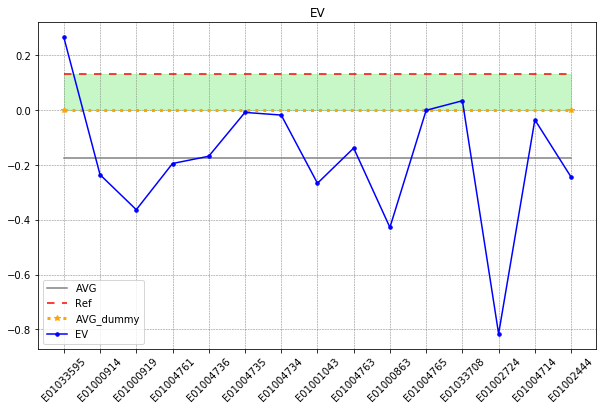

In [184]:
plot_score_lsoa(dic, dic2, "ev", "EV","EV")

#### MAE (MEAN ABSOLUTE ERROR)

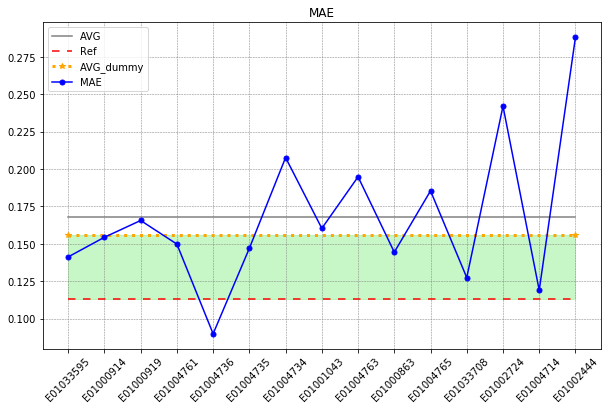

In [182]:
plot_score_lsoa(dic, dic2, "mae", "MAE", "MAE")

#### R2

The majority are above the average but *R2* is still very low.

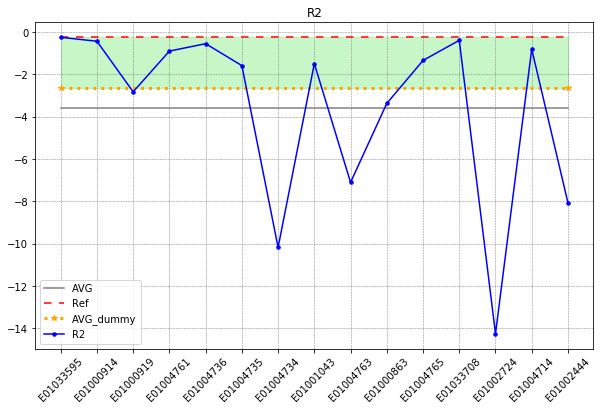

In [185]:
plot_score_lsoa(dic, dic2, "r2", "R2","R2")

#### Correlation

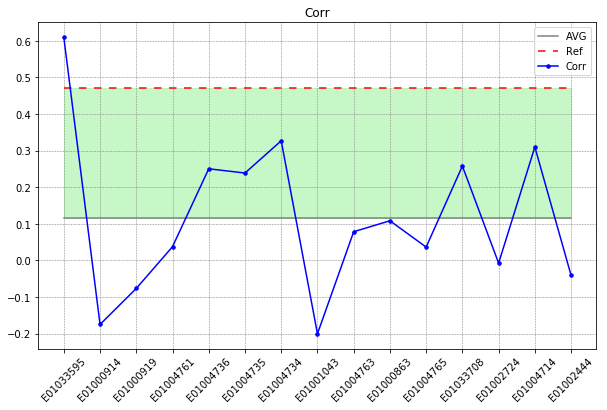

In [188]:
plot_score_lsoa(dic, dic2, "corr", "Corr","Corr")

As we can see the majority of LSOA has a score withing the goodness interval, and in some case the model behaves better than the reference-LSOA execution. So these plots confirmed that the model is quite stable with the respect to elements of the same cluster.

<a id='concl'></a> 
## 4. Conclusions [to top](#top)

Our investigation of London Crime data led to interesting discoveries. Looking at how the number of cimes varies over the year between 2008 and 2016 we found that the trend is costant but for a suspicious peak in 2012. A further analysis showed that the peak was due to a critical increase in Theft and Handling felonies. We thought that the presence of the Olympic games gathered a lot of tourists, that is a category of victim of such type of crimes.

Instead, looking at how the number of crimes varies over the month of a year we noticed that the city tends to be safer on February and more dangerous on March, but apart from those small fluctations the trend is quite regular.

Another important discovery is that within a year the different types of crimes mantain the same proportions: the more frequent are always theft, violence and criminal damages. Among these most frequent crimes, the Violence-related ones are the most concerning, critically increasing, doubling in the last three years. On the contrary Drugs crimes are suffering an almost linear descent during the past years, maybe due to the installation of new [survelliance cameras](http://google.com) all over the city. Unfortunately the location data of this cameras is very difficult to find because those data often belong to private property or shops. 

Furthermore we observed interesting strong correlation between the number of monuments in a borough and the number of theft felonies. This could be explained by the greater number of tourist near the city attractions that can be an incentive for pickpockets. Nevertheless the strongest correlations have been observed among the different type of crimes both at borough and LSOA level. This made us think that in the captial there's some *crime locality*, in the sense that the different type of crimes tend to behave similarly (grow and decresase in the same way) within a specific zone.

This supposition was further confirmed by chloropleth maps where, whatever the crime category, LSOA with high values of crimes are mostly near the upper bank of the Thames and the city centre, surrounded by LSOA with low values of crime; and this situation repeats over the years. 

A clustering analysis over the values of crime in the LSOAs allowed us both to separate zones of London according to their dangerousness and to spot the most dangerous ones.

Combining all those results with the distribution analysis of the crime value over the LSOAs
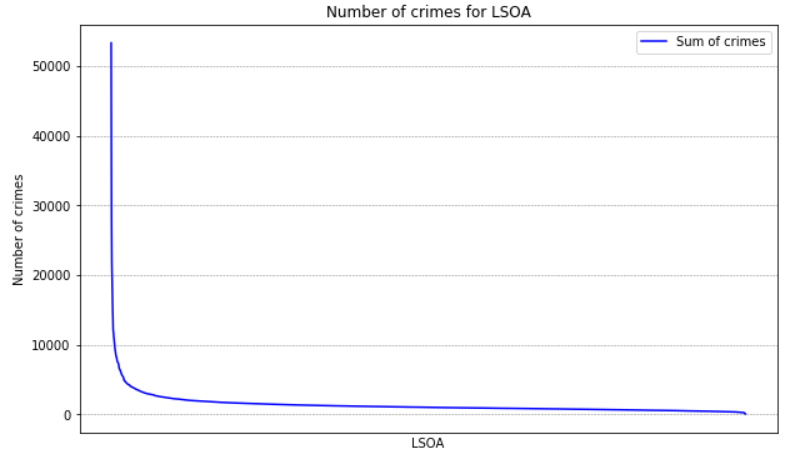

We have been able to understand that the high-crime-risk zones are rare and isolated, in fact the plot above depicts a power-law situation, so we'll have a lot of LSOA with low crime values and a few very dangerous.

The final output of our analysis is a couple of models: one that predicts in which class of danger will be a borough in the next month, the other that predicts the number of crimes that will happen in an LSOA in the next month.

A possible usage scenario is one in which the range predictor is used in order to have a general idea of the class of risk of each borough. Once we found the most dangerous one we can use the LSOA regressor to have a preciser idea of what will happen and how to deploy the aviable resources in a smart way, given taht high risk zones are rare and isolated.